In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import gensim.models
import fasttext
from keras.utils.vis_utils import plot_model
from gensim.models import KeyedVectors
import shutil

In [2]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df.head()
df2 = df.copy()


In [3]:
df.head()


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
#There are only two news websites - theonion.com and huffingtonpost.com. There is a form of bias in claiming sarcasm is only attributed to headlines from the onion and 
#non-sarcastic headlines from the huffington post

Newspaper = []
for row in df['article_link']:
    if 'theonion.com' in row : Newspaper.append('The Onion')
    elif 'huffingtonpost.com' in row : Newspaper.append('Huffington Post')
    else: Newspaper.append('Something else')
# Create set to check the unique values of 'Newspaper'
set_Newspaper = set(Newspaper) 
print(set_Newspaper)
df['Web-site'] = Newspaper


{'The Onion', 'Huffington Post'}


In [5]:
#Drop the 'article_link' column. It is not usefull.
df.drop('article_link', axis = 1, inplace = True)


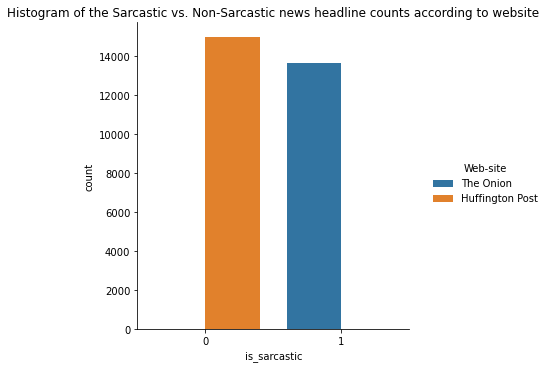

In [6]:
sns.catplot(data=df, x="is_sarcastic", hue="Web-site", kind="count").set(title='Histogram of the Sarcastic vs. Non-Sarcastic news headline counts according to website') 

This dataset considers The Onion as the only source of sarcasm and Huffington Post as the only source for non-sarcasm



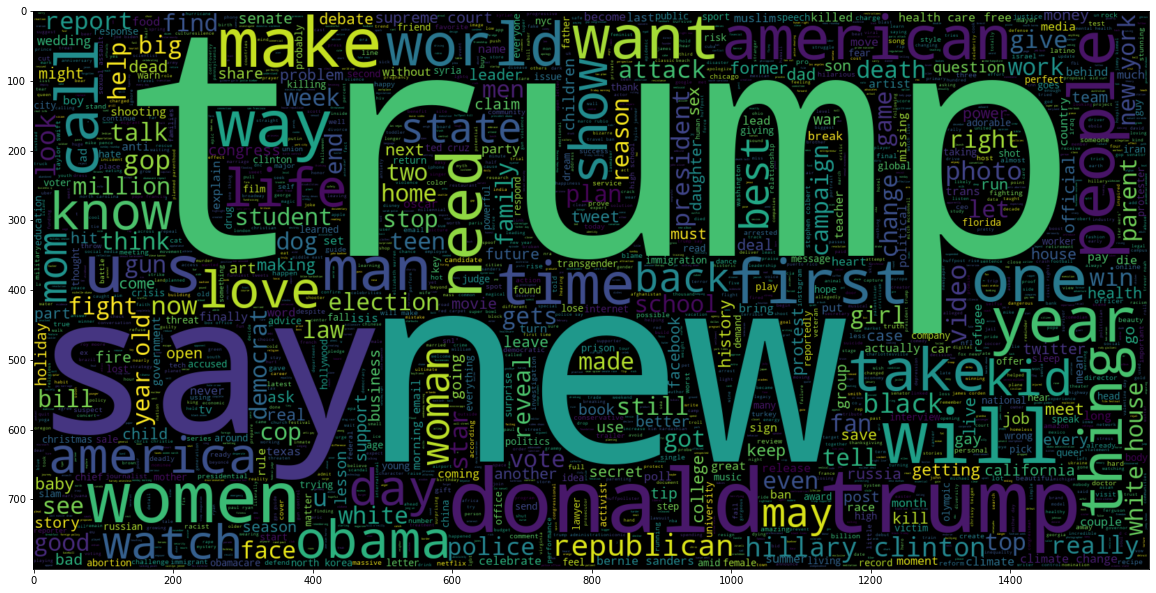

In [7]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

In [8]:
non_sarcastic_frequent_words_list = list(wc.words_.keys())[:10]
print(non_sarcastic_frequent_words_list[:10])

['trump', 'new', 'say', 'donald trump', 'will', 'women', 'make', 'u s', 'way', 'one']


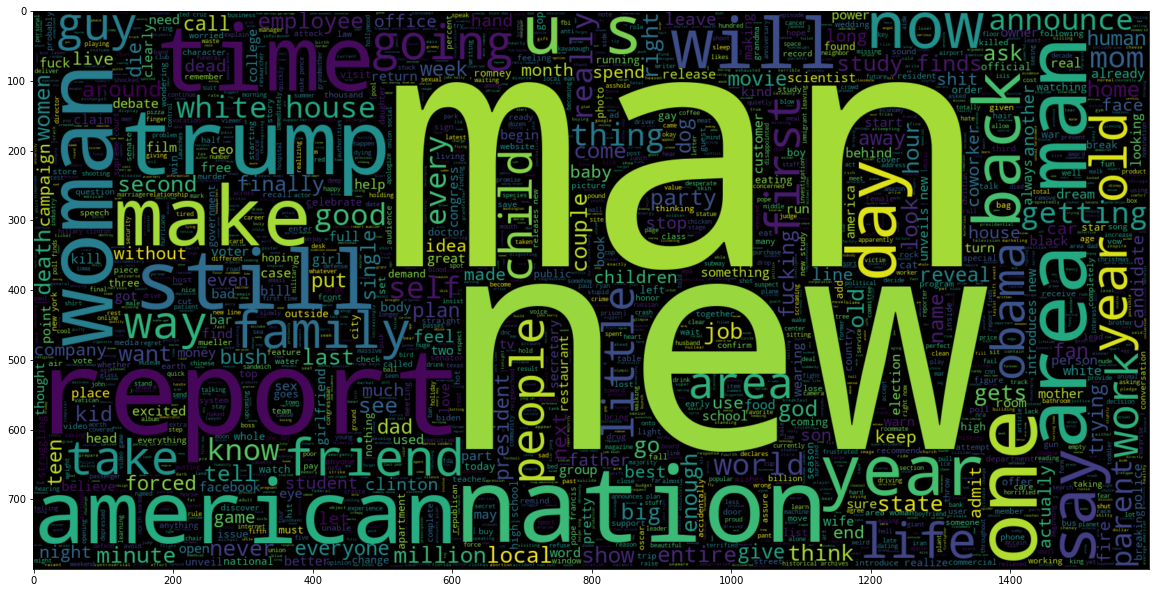

In [9]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')


In [10]:
sarcastic_frequent_words_list = list(wc.words_.keys())[:10]
print(sarcastic_frequent_words_list[:10])

['man', 'new', 'report', 'nation', 'woman', 'time', 'trump', 'american', 'one', 'area man']


In [11]:
#Show the most frequent similar words:
s = set(sarcastic_frequent_words_list)
same_frequent_words = [x for x in non_sarcastic_frequent_words_list if x in s]
print(same_frequent_words)

['trump', 'new', 'one']


In [12]:
#creating copy of dataset
df2 = df.copy()
df2 = df2.drop(df2[df2['headline'] == ''].index)

In [13]:
#Use of data cleaing via convertion to lower case characters, 
#removing punctuation, keeping alphabetic characters and filtering
#out stop words
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [14]:
#Apply function on review column
df2['headline']=df2['headline'].apply(denoise_text)

In [15]:
df2 = df2.drop('Web-site', axis = 1 )


In [16]:
df2.head()


,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


In [17]:
#Get headlines' values as documents

docs = df2['headline'].values


In [18]:
# fit a tokenizer
#We will a tokenizer to both define the vocabulary for the Embedding layer and encode the headlines 
#as integers. We also need to know the size of the vocabulary for the Embedding layer.
t = Tokenizer()
t.fit_on_texts(docs)
# calculate vocabulary size
vocab_size = len(t.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)

Vocabulary size: 28568


In [19]:
#We also need to know the maximum length of input sequences as 
#input for the model and to pad all sequences to the fixed length.
max_length = np.max([len(s.split()) for s in docs])
print('Maximum length: %d' % max_length)

Maximum length: 106


In [20]:
#Integer encode and pad the headlines text - 'x' matrix
x = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [21]:
print(x.shape)


(28619, 106)


In [22]:
#Get the median sentence length. It is used, in thw Word2vec model, as the frame window 
#for closed words for each word in the corpus.
window_as_median_sentence_length = np.median([len(s.split()) for s in docs]).astype(int)
print('Median words sentence length: %d' % window_as_median_sentence_length)

Median words sentence length: 7


In [23]:
#As an input of the gensim.models.Word2Vec, we split each headline to words:
words = []
for i in docs:
    words.append(i.split())

In [24]:
W2V_Headlines = gensim.models.Word2Vec(sentences = words , vector_size=300 , window = window_as_median_sentence_length , min_count = 1)

In [25]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        # update embedding matrix using Headlines Embedding
        embedding_vector = W2V_Headlines.wv.get_vector(word, norm=True)
        embedding_matrix[i] = embedding_vector
    except:
        # when word isn't found in Headlines, we keep the embedding matrix unchanged at that index (assigned to zero)
        pass

Train the Word2Vec model for the headlines Embedding

The real valued vector representation for words can be learned while training the neural network.

We use a Recurrent Neural Network (RNN). We will use a 300-dimensional vector space. Finally, the maximum document length was calculated above in the max_length variable used during padding. The complete model definition is listed below. The output layer uses a sigmoid activation to output a value between 0 and 1 for the negative and positive sarcasm in the headlines.

In [26]:
#Defining Neural Network
model_w2v_Headlines = Sequential()
#Non-trainable embeddidng layer
model_w2v_Headlines.add(Embedding(vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=True))
#LSTM 
model_w2v_Headlines.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model_w2v_Headlines.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model_w2v_Headlines.add(Dense(1, activation='sigmoid'))
model_w2v_Headlines.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

2022-10-11 17:12:30.272344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model_w2v_Headlines.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 106, 300)          8570400   
                                                                 
 bidirectional (Bidirectiona  (None, 106, 256)         439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 9,065,441
Trainable params: 9,065,441
Non-trainable params: 0
_________________________________________________________________


In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, df2.is_sarcastic , test_size = 0.3 , random_state = 0) 


In [30]:
history_w2v_Headlines = model_w2v_Headlines.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 10)


Epoch 1/10
157/157 [==============================] - 164s 995ms/step - loss: 0.5038 - acc: 0.7426 - val_loss: 0.4225 - val_acc: 0.8079
Epoch 2/10
157/157 [==============================] - 160s 1s/step - loss: 0.1835 - acc: 0.9301 - val_loss: 0.5114 - val_acc: 0.8040
Epoch 3/10
157/157 [==============================] - 152s 970ms/step - loss: 0.0647 - acc: 0.9775 - val_loss: 0.6906 - val_acc: 0.7986
Epoch 4/10
157/157 [==============================] - 153s 972ms/step - loss: 0.0277 - acc: 0.9912 - val_loss: 0.9020 - val_acc: 0.7915
Epoch 5/10
157/157 [==============================] - 167s 1s/step - loss: 0.0147 - acc: 0.9956 - val_loss: 1.0202 - val_acc: 0.7928
Epoch 6/10
157/157 [==============================] - 152s 969ms/step - loss: 0.0116 - acc: 0.9966 - val_loss: 1.0466 - val_acc: 0.7890
Epoch 7/10
157/157 [==============================] - 151s 961ms/step - loss: 0.0093 - acc: 0.9972 - val_loss: 1.2222 - val_acc: 0.7871
Epoch 8/10
157/157 [==============================] - 

In [31]:
print("Accuracy of the w2v_Headlines model on Training Data is - " , model_w2v_Headlines.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the w2v_Headlines model on Testing Data is - " , model_w2v_Headlines.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 44s 70ms/step - loss: 0.0055 - acc: 0.9989
Accuracy of the w2v_Headlines model on Training Data is -  99.88518953323364
269/269 [==============================] - 19s 70ms/step - loss: 1.2457 - acc: 0.7846
Accuracy of the w2v_Headlines model on Testing Data is -  78.46494317054749


In [32]:
print("Classification report for w2v_Headlines:")
pred = np.round_(model_w2v_Headlines.predict(x_test))
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))
cm = confusion_matrix(y_test,pred)
print('confusion matrix:\n')
print(cm)

Classification report for w2v_Headlines:
269/269 [==============================] - 19s 69ms/step
               precision    recall  f1-score   support

Not Sarcastic       0.79      0.81      0.80      4560
    Sarcastic       0.78      0.75      0.77      4026

     accuracy                           0.78      8586
    macro avg       0.78      0.78      0.78      8586
 weighted avg       0.78      0.78      0.78      8586

confusion matrix:

[[3702  858]
 [ 991 3035]]


<AxesSubplot:>

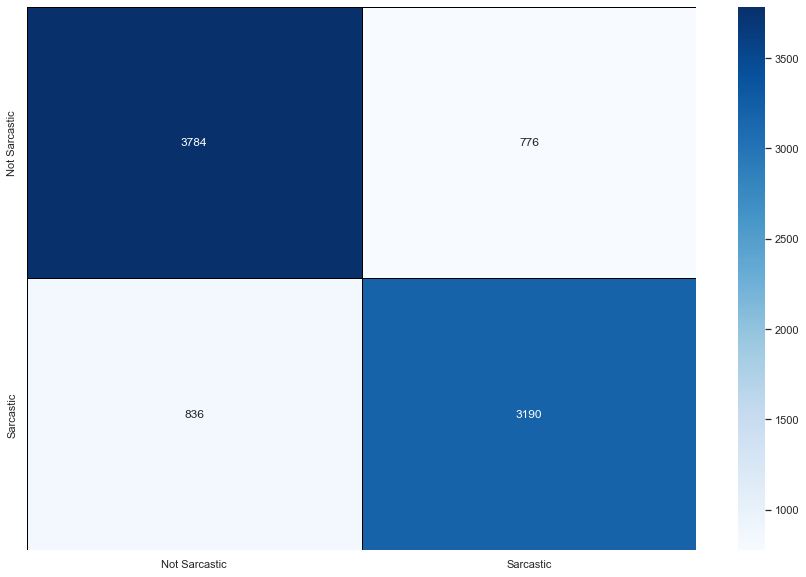

In [49]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (15,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']) 
# plt.savefig("cm_w2v_Headlines.png")

In [34]:
filepath = 'glove.42B.300d.txt'
# load the whole embedding into memory
embeddings_index = dict()
f = open(filepath, mode='rt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 1917495 word vectors.


In [35]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
#Defining Neural Network
model_glove = Sequential()
#Non-trainable embeddidng layer
model_glove.add(Embedding(vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=True))
#LSTM 
model_glove.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model_glove.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, df2.is_sarcastic , test_size = 0.3 , random_state = 0) 


In [38]:
history_glove = model_glove.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 10)


Epoch 1/10
157/157 [==============================] - 156s 947ms/step - loss: 0.4417 - acc: 0.7920 - val_loss: 0.3692 - val_acc: 0.8373
Epoch 2/10
157/157 [==============================] - 149s 952ms/step - loss: 0.1511 - acc: 0.9424 - val_loss: 0.4410 - val_acc: 0.8268
Epoch 3/10
157/157 [==============================] - 152s 967ms/step - loss: 0.0513 - acc: 0.9813 - val_loss: 0.6684 - val_acc: 0.8220
Epoch 4/10
157/157 [==============================] - 967s 6s/step - loss: 0.0202 - acc: 0.9925 - val_loss: 0.9478 - val_acc: 0.8102
Epoch 5/10
157/157 [==============================] - 160s 1s/step - loss: 0.0135 - acc: 0.9961 - val_loss: 0.8637 - val_acc: 0.8174
Epoch 6/10
157/157 [==============================] - 161s 1s/step - loss: 0.0144 - acc: 0.9950 - val_loss: 0.9456 - val_acc: 0.8177
Epoch 7/10
157/157 [==============================] - 168s 1s/step - loss: 0.0101 - acc: 0.9967 - val_loss: 1.0711 - val_acc: 0.8148
Epoch 8/10
157/157 [==============================] - 165s 1

In [39]:
print("Accuracy of the glove model on Training Data is - " , model_glove.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the glove model on Testing Data is - " , model_glove.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 47s 75ms/step - loss: 0.0026 - acc: 0.9992
Accuracy of the glove model on Training Data is -  99.92012977600098
269/269 [==============================] - 20s 74ms/step - loss: 1.0670 - acc: 0.8123
Accuracy of the glove model on Testing Data is -  81.22525215148926


In [40]:
print("Classification report for glove:")
pred = np.round_(model_glove.predict(x_test))
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))
cm = confusion_matrix(y_test,pred)
print('confusion matrix:\n')
print(cm)

Classification report for glove:
269/269 [==============================] - 21s 74ms/step
               precision    recall  f1-score   support

Not Sarcastic       0.82      0.83      0.82      4560
    Sarcastic       0.80      0.79      0.80      4026

     accuracy                           0.81      8586
    macro avg       0.81      0.81      0.81      8586
 weighted avg       0.81      0.81      0.81      8586

confusion matrix:

[[3784  776]
 [ 836 3190]]


<AxesSubplot:>

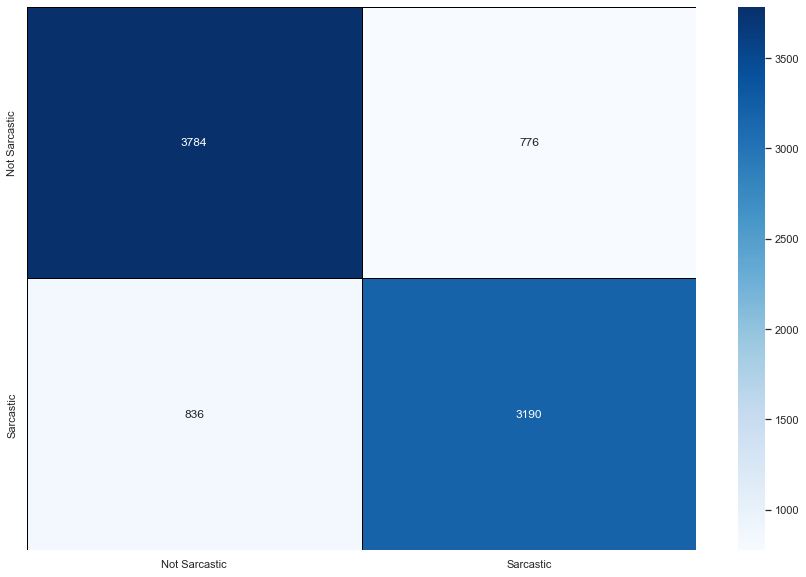

In [48]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (15,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']) 

In [42]:
train_acc_w2v_Headlines	  = history_w2v_Headlines.history['acc']
train_loss_w2v_Headlines  = history_w2v_Headlines.history['loss']
val_acc_w2v_Headlines     = history_w2v_Headlines.history['val_acc']
val_loss_w2v_Headlines    = history_w2v_Headlines.history['val_loss']

train_acc_glove  = history_glove.history['acc']
train_loss_glove = history_glove.history['loss']
val_acc_glove     = history_glove.history['val_acc']
val_loss_glove    = history_glove.history['val_loss']



data_preproc_val_acc = pd.DataFrame({
    'w2v': val_acc_w2v_Headlines,
    'glove': val_acc_glove})
data_preproc_val_acc.index = np.arange(1, len(data_preproc_val_acc) + 1)

data_preproc_val_loss = pd.DataFrame({
    'w2v': val_loss_w2v_Headlines,
    'glove': val_loss_glove})
data_preproc_val_loss.index = np.arange(1, len(data_preproc_val_loss) + 1)

data_preproc_train_acc = pd.DataFrame({
    'w2v': train_acc_w2v_Headlines,
    'glove': train_acc_glove})
data_preproc_train_acc.index = np.arange(1, len(data_preproc_train_acc) + 1)

data_preproc_train_loss = pd.DataFrame({
    'w2v': train_loss_w2v_Headlines,
    'glove': train_loss_glove})
data_preproc_train_loss.index = np.arange(1, len(data_preproc_train_loss) + 1)

[Text(0.5, 1.0, 'Training Loss')]

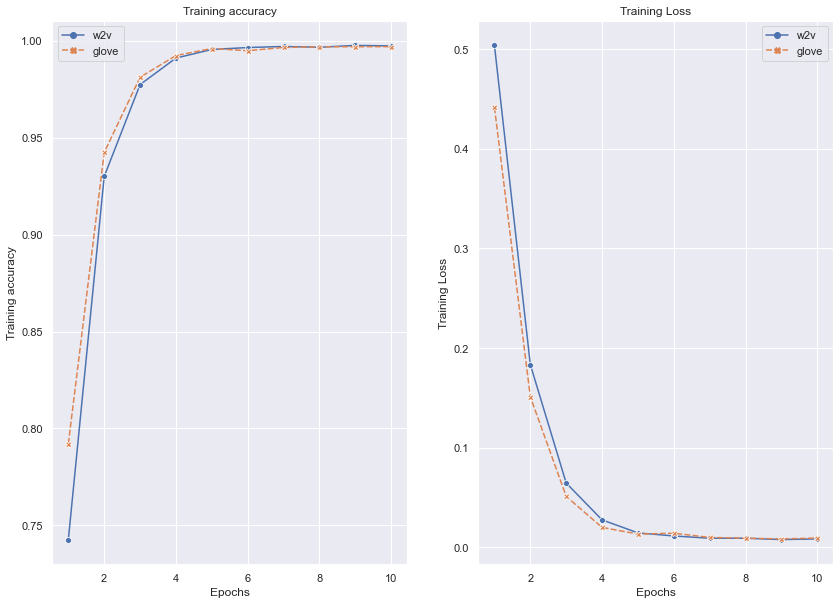

In [45]:
sns.set(rc={'figure.figsize':(14,10)})
fig, axes = plt.subplots(1, 2)

train_acc_plot = sns.lineplot(data=data_preproc_train_acc, markers=True, ax=axes[0])
train_acc_plot.set_xlabel("Epochs")
train_acc_plot.set_ylabel("Training accuracy")
train_acc_plot.set(title='Training accuracy')

train_loss_plot = sns.lineplot(data=data_preproc_train_loss, markers=True, ax=axes[1])
train_loss_plot.set_xlabel("Epochs")
train_loss_plot.set_ylabel("Training Loss")
train_loss_plot.set(title='Training Loss')

[Text(0.5, 1.0, 'Validation Loss')]

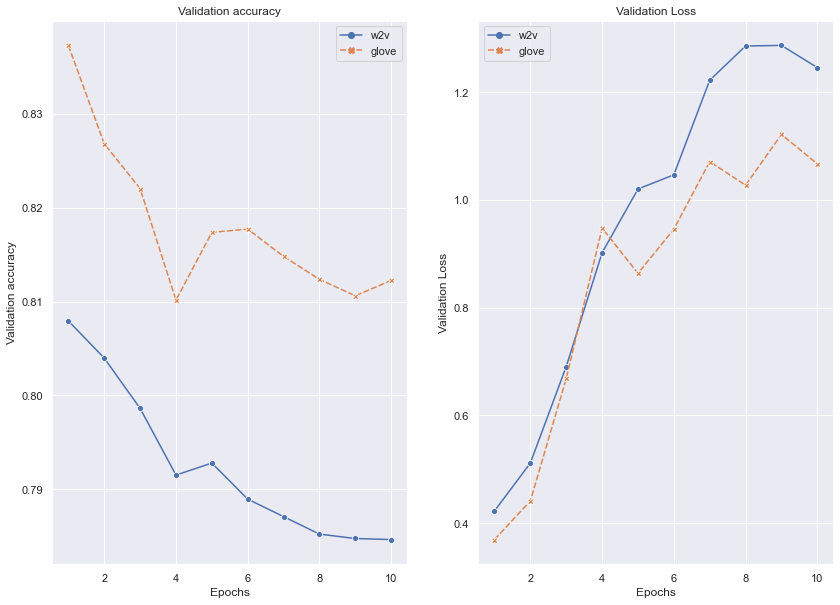

In [46]:
sns.set(rc={'figure.figsize':(14,10)})
fig, axes = plt.subplots(1, 2)

val_acc_plot = sns.lineplot(data=data_preproc_val_acc, markers=True, ax=axes[0])
val_acc_plot.set_xlabel("Epochs")
val_acc_plot.set_ylabel("Validation accuracy")
val_acc_plot.set(title='Validation accuracy')

val_loss_plot = sns.lineplot(data=data_preproc_val_loss, markers=True, ax=axes[1])
val_loss_plot.set_xlabel("Epochs")
val_loss_plot.set_ylabel("Validation Loss")
val_loss_plot.set(title='Validation Loss')